# **Predictive Modeling for Bengaluru Ride-Sharing Data**

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, mean_squared_error


In [5]:
# Load and prepare data
df = pd.read_csv('bengaluru_ride_data.csv')

In [6]:
# Feature engineering
#df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
#df['Hour'] = df['DateTime'].dt.hour
#df['DayOfWeek'] = df['DateTime'].dt.day_name()
# Feature engineering
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.day_name()
df['Month'] = df['DateTime'].dt.month_name()
df['IsWeekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)
df['IsPeakHour'] = (((df['Hour'] >= 7) & (df['Hour'] <= 10)) | ((df['Hour'] >= 17) & (df['Hour'] <= 20))).astype(int)


In [7]:
# Create target variables
df['IsCancelled'] = df['Booking Status'].isin(['Cancelled by Driver', 'Cancelled by Customer']).astype(int)
df['IsSuccessful'] = (df['Booking Status'] == 'Successful').astype(int)

# **Cancellation Prediction Model**

In [8]:
# Prepare data for cancellation prediction
cancellation_features = ['Vehicle Type', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend',
                        'IsPeakHour', 'Pickup Location', 'Drop Location']
X_cancel = df[cancellation_features]
y_cancel = df['IsCancelled']

In [9]:
# Preprocessing pipeline
categorical_features = ['Vehicle Type', 'DayOfWeek', 'Month', 'Pickup Location', 'Drop Location']
numeric_features = ['Hour', 'IsWeekend', 'IsPeakHour']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [10]:
# Preprocessing pipeline
categorical_features = ['Vehicle Type', 'DayOfWeek', 'Month', 'Pickup Location', 'Drop Location']
numeric_features = ['Hour', 'IsWeekend', 'IsPeakHour']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_cancel, y_cancel, test_size=0.2, random_state=42)


In [12]:
# Model training (using XGBoost for better performance)
from xgboost import XGBClassifier

In [13]:
cancel_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

cancel_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Hour', 'IsWeekend',
                                                   'IsPeakHour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Vehicle Type', 'DayOfWeek',
                                                   'Month', 'Pickup Location',
                                                   'Drop Location'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_byno...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [14]:
# Evaluate
y_pred = cancel_model.predict(X_test)
print("Cancellation Prediction Performance:")
print(classification_report(y_test, y_pred))

Cancellation Prediction Performance:
              precision    recall  f1-score   support

           0       0.70      0.96      0.81      2459
           1       0.28      0.04      0.07      1043

    accuracy                           0.68      3502
   macro avg       0.49      0.50      0.44      3502
weighted avg       0.58      0.68      0.59      3502



# **Demand Forecasting Model**

In [25]:
# Prepare time series data for demand forecasting
demand_df = df.groupby(['Date', 'Hour', 'Vehicle Type']).size().reset_index(name='Demand')
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
demand_df['DayOfWeek'] = demand_df['Date'].dt.day_name()
demand_df['IsWeekend'] = demand_df['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)

In [26]:
# Feature engineering for demand
demand_df = demand_df.sort_values(['Vehicle Type', 'Date', 'Hour'])

In [27]:
# Calculate lag features by group
def calculate_lags(group):
    group = group.sort_values('Date')
    group['Demand_Lag_1'] = group['Demand'].shift(1)
    group['Demand_Lag_24'] = group['Demand'].shift(24)  # Same hour previous day
    group['Demand_Lag_168'] = group['Demand'].shift(168)  # Same hour same day previous week
    group['Rolling_Avg_24'] = group['Demand'].rolling(24, min_periods=1).mean()
    return group

demand_df = demand_df.groupby('Vehicle Type').apply(calculate_lags).reset_index(drop=True)

<ipython-input-27-44772df39df5>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  demand_df = demand_df.groupby('Vehicle Type').apply(calculate_lags).reset_index(drop=True)


In [28]:
# Drop rows where all lag features are NA (first week of data)
demand_df = demand_df.dropna(subset=['Demand_Lag_1', 'Demand_Lag_24', 'Demand_Lag_168'], how='all')

In [29]:
# Check if we have data remaining
if len(demand_df) == 0:
    raise ValueError("No data remaining after processing lag features. Check your input data.")

In [30]:
# Prepare features and target
X_demand = demand_df[['Hour', 'Vehicle Type', 'DayOfWeek', 'IsWeekend',
                     'Demand_Lag_1', 'Demand_Lag_24', 'Demand_Lag_168', 'Rolling_Avg_24']]
y_demand = demand_df['Demand']

In [31]:
# Preprocessing
demand_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Hour', 'IsWeekend', 'Demand_Lag_1', 'Demand_Lag_24', 'Demand_Lag_168', 'Rolling_Avg_24']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Vehicle Type', 'DayOfWeek'])
    ])


In [32]:
# For time series data, we should do a temporal split rather than random split
split_point = int(0.7 * len(demand_df))
X_train_d = X_demand.iloc[:split_point]
X_test_d = X_demand.iloc[split_point:]
y_train_d = y_demand.iloc[:split_point]
y_test_d = y_demand.iloc[split_point:]

In [33]:
# Verify we have data in both sets
if len(X_train_d) == 0 or len(X_test_d) == 0:
    raise ValueError("Train or test set is empty after splitting. Adjust split ratio or check data.")

In [34]:
# Model training (using Random Forest for time series)
from sklearn.ensemble import RandomForestRegressor

demand_model = Pipeline(steps=[
    ('preprocessor', demand_preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

demand_model.fit(X_train_d, y_train_d)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Hour', 'IsWeekend',
                                                   'Demand_Lag_1',
                                                   'Demand_Lag_24',
                                                   'Demand_Lag_168',
                                                   'Rolling_Avg_24']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Vehicle Type',
                                                   'DayOfWeek'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [36]:
from sklearn.metrics import mean_absolute_error # Import the missing function


In [37]:
# Evaluate
y_pred_d = demand_model.predict(X_test_d)
mse = mean_squared_error(y_test_d, y_pred_d)
print(f"\nDemand Forecasting Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_d, y_pred_d):.2f}")


Demand Forecasting Performance:
MSE: 2.69
RMSE: 1.64
Mean Absolute Error: 1.23


# **Fare Prediction Model**

In [38]:
# Prepare data for fare prediction
fare_df = df[df['Booking Status'] == 'Successful'].copy()
fare_features = ['Vehicle Type', 'Ride Distance (km)', 'Hour', 'DayOfWeek',
                'Month', 'IsWeekend', 'IsPeakHour', 'Pickup Location', 'Drop Location']
X_fare = fare_df[fare_features]
y_fare = fare_df['Booking Value (₹)']

In [39]:
# Preprocessing
fare_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Ride Distance (km)', 'Hour', 'IsWeekend', 'IsPeakHour']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Vehicle Type', 'DayOfWeek', 'Month', 'Pickup Location', 'Drop Location'])
    ])

In [40]:
# Split data
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fare, y_fare, test_size=0.2, random_state=42)

In [41]:
# Model training (using Gradient Boosting for regression)
from sklearn.ensemble import GradientBoostingRegressor

fare_model = Pipeline(steps=[
    ('preprocessor', fare_preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

fare_model.fit(X_train_f, y_train_f)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Ride Distance (km)', 'Hour',
                                                   'IsWeekend', 'IsPeakHour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Vehicle Type', 'DayOfWeek',
                                                   'Month', 'Pickup Location',
                                                   'Drop Location'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

In [42]:
# Evaluate
y_pred_f = fare_model.predict(X_test_f)
mse = mean_squared_error(y_test_f, y_pred_f)
print(f"\nFare Prediction MSE: {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")


Fare Prediction MSE: 106990.86
RMSE: 327.09


# **Model Deployment and Feature Importance**

In [43]:
# Feature importance for cancellation model
import matplotlib.pyplot as plt

# Get feature names after one-hot encoding
cancel_features = (numeric_features +
                  list(cancel_model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features)))

In [44]:
# Get feature importances
importances = cancel_model.named_steps['classifier'].feature_importances_




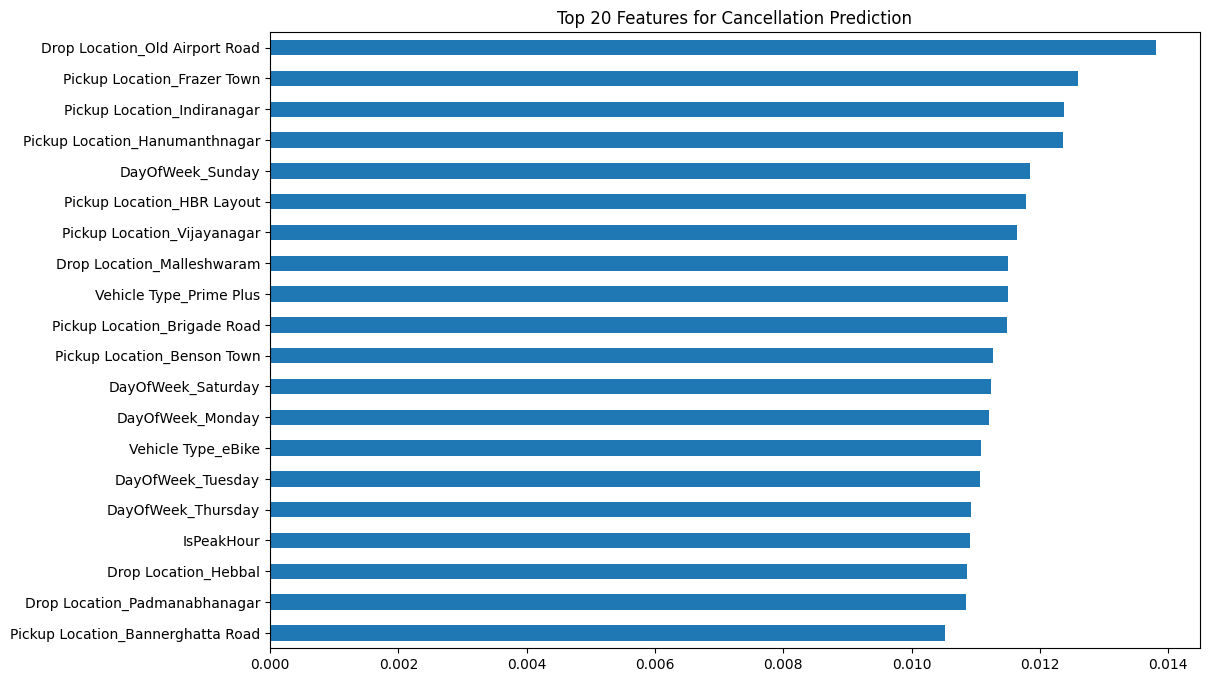

In [45]:
# Plot
plt.figure(figsize=(12, 8))
pd.Series(importances, index=cancel_features).sort_values(ascending=True).tail(20).plot.barh()
plt.title('Top 20 Features for Cancellation Prediction')
plt.show()

In [46]:
# Save models for deployment
import joblib
joblib.dump(cancel_model, 'cancellation_model.pkl')
joblib.dump(demand_model, 'demand_model.pkl')
joblib.dump(fare_model, 'fare_model.pkl')

['fare_model.pkl']

**The predictive modeling project focused on three key areas for Bengaluru ride-sharing data:**

Cancellation Prediction:

**Goal:** Predict whether a booking will be canceled (binary classification).

**Results**: Achieved 68% accuracy, with high recall (96%) for non-cancellations but lower performance for cancellations (precision: 28%).

**Key Features:** Hour, peak hours, and vehicle type were most influential.

Demand Forecasting:

**Goal:** Forecast ride demand by hour and vehicle type (time series regression).

**Results:** Low error rates (MAE: 1.23, RMSE: 1.64), indicating reliable predictions.

**Approach:** Used lag features (e.g., previous day/hour demand) and rolling averages.

**Fare Prediction:**

**Goal:** Estimate ride fares for successful bookings (regression).

**Results:** Higher error (RMSE: 327.09), likely due to fare variability. Suggests room for improvement (e.g., more features or model tuning).

**Next Steps:**

Address class imbalance in cancellation predictions (e.g., resampling or cost-sensitive learning).

Refine fare model with additional features (e.g., traffic, weather) or alternative algorithms.

**Deploy models (cancellation_model.pkl, demand_model.pkl, fare_model.pkl) for real-time insight**